<a href="https://colab.research.google.com/github/Nithinps021/DeepLearning/blob/master/hands__on_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tarfile
from six.moves import urllib

In [3]:
DOWNLOAD_ROOT="https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH='datasets/housing'
HOUSING_URL=DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

def fetch_data(housing_url=HOUSING_URL,housing_path=HOUSING_PATH):
  if not os.path.isdir(housing_path):
    os.makedirs(housing_path)
  tgz_path=os.path.join(housing_path,'housing.tgz')
  urllib.request.urlretrieve(housing_url,tgz_path)
  housing_tgz=tarfile.open(tgz_path)
  housing_tgz.extractall(path='sample_data/'+housing_path)
  housing_tgz.close()
  
fetch_data()


In [4]:
import pandas as pd

def loadHousingData(housing_path='sample_data/'+HOUSING_PATH):
  path_housing_csv=os.path.join(housing_path,'housing.csv')
  return pd.read_csv(path_housing_csv)

In [ ]:
housingData=loadHousingData()
housingData.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housingData.describe()
housingData["median_income"].value_counts()

3.1250     49
15.0001    49
2.8750     46
4.1250     44
2.6250     44
           ..
4.1514      1
1.2614      1
2.0294      1
6.7079      1
3.7306      1
Name: median_income, Length: 12928, dtype: int64

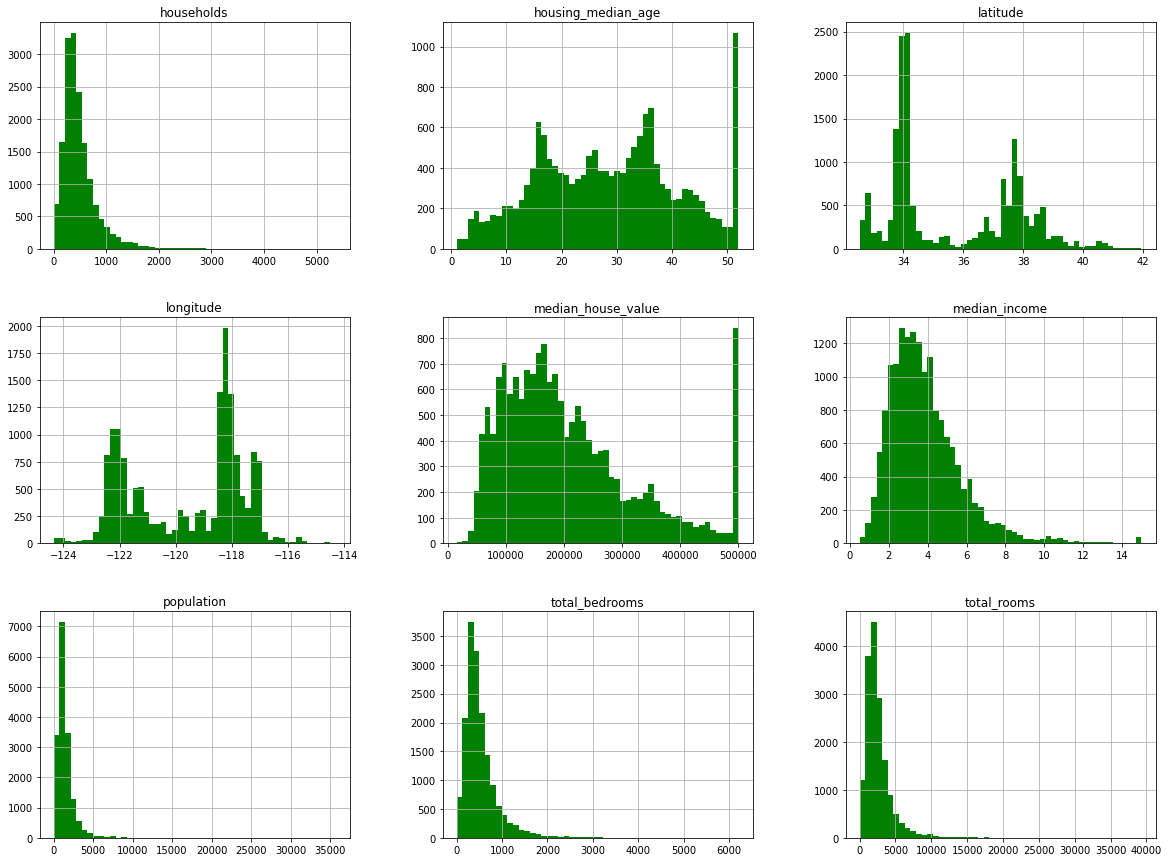

In [ ]:
import matplotlib.pyplot as plt

housingData.hist(bins=50,figsize=(20,15),color='green')
plt.show()

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit


# def shuffle_data(data,testSize):
#   shuffled_indices=np.random.permutation(len(data))
#   test_size=int(len(data)*testSize)
#   test_indices=shuffled_indices[:test_size]
#   train_indices=shuffled_indices[test_size:]
#   return data.iloc[test_indices] ,  data.iloc[train_indices]

# testData,trainData = shuffle_data(housingData,0.2)

# using sklearn train_test_split method

# from sklearn.model_selection import train_test_split
# train_data, test_data=train_test_split(housingData,test_size=0.2,random_state=42)

# print(len(train_data),len(test_data))


# StratifiedShuffleSplit

housingData['income_cat']=np.ceil(housingData['median_income']/1.5)
housingData['income_cat'].where(housingData['income_cat']<5,5.0,inplace=True)
splitData=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for trainIndex,testIndex in splitData.split(housingData,housingData['income_cat']):
  train_data=housingData.iloc[trainIndex]
  test_data=housingData.iloc[testIndex]
for  i in (train_data,test_data):
  i.drop(['income_cat'],axis=1,inplace=True)
housingData=train_data.copy()

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


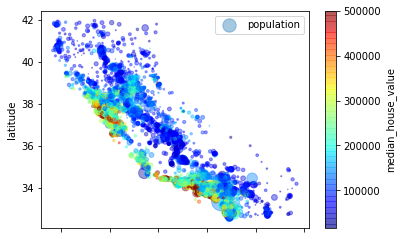

In [ ]:
housingData.plot(kind='scatter',x='longitude',y='latitude',alpha=0.4,
                 s=housingData['population']/100,label='population',
                 c='median_house_value',cmap=plt.get_cmap('jet'),colorbar=True
                 )
plt.legend()

In [ ]:
# correlation matrix

cor_matrix=housingData.corr()
cor_matrix['median_income'].sort_values(ascending=False)
housingD

median_income         1.000000
median_house_value    0.687160
total_rooms           0.200087
households            0.010781
population            0.002380
total_bedrooms       -0.009740
longitude            -0.019583
latitude             -0.075205
housing_median_age   -0.111360
Name: median_income, dtype: float64